# 写真からラーメンの種類を判別するモデルを作成

## 機能概要
写真データからラーメンの種類を判定
<br>
判別種類:<br>
- 醤油
- 味噌
- 豚骨
- 二郎系
- 家系

## インポート

In [1]:
!pip install japanize_matplotlib
!pip install torch
!pip install torchinfo
!pip install torchviz
!pip install torchvision

# Standard
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import os

# PyTorch
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

## 定数

In [2]:
TRAIN_DATA_PATH = r"C:\\Users\\peper\\OneDrive\\TrainingData\\RamenAi"
DATA_SET_PATH = r"C:\\Users\\peper\\OneDrive\\TrainingData\\DataSet"

## モデル作成

In [3]:
# Init Setup

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 共通関数の読み込み

In [5]:
import sys
sys.path.append('..')

# 共通関数のロード
import importlib
import PyTorch_lib.lib1
importlib.invalidate_caches()
importlib.reload(PyTorch_lib.lib1)
from PyTorch_lib.lib1 import *

# 共通関数の存在チェック
print(README)

Common Library for PyTorch
Author: H. Hiroshi
Ver:1.0.1


## データ準備

In [6]:
import glob

data_dirs = glob.glob(TRAIN_DATA_PATH + "/*/")

## Transforms定義

In [7]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(1),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

## データセット定義

In [8]:
# ファイルを分ける
from sklearn.model_selection import train_test_split

train_files = np.zeros(1)
test_files = np.zeros(1)
for data_dir in data_dirs:
    train_add_files, test_add_files = train_test_split(glob.glob(data_dir + "/*"), train_size=0.7, test_size=0.3, random_state=123)
    train_files = np.append(train_files, train_add_files)
    test_files = np.append(test_files, test_add_files)

print(train_files.shape)
print(test_files.shape)
train_files = np.delete(train_files, 0, axis=0)
test_files = np.delete(test_files, 0, axis=0)
print(train_files.shape)
print(test_files.shape)

(172,)
(80,)
(171,)
(79,)


In [9]:
# 学習データ内のフォルダ検索
all_file_dir = os.listdir(TRAIN_DATA_PATH)

# 分類先クラスのリスト作成
classes = [f for f in all_file_dir if os.path.isdir(os.path.join(TRAIN_DATA_PATH, f))]

In [10]:
import shutil
from PIL import Image

if os.path.exists(DATA_SET_PATH):
    # DataSetフォルダを消す
    shutil.rmtree(DATA_SET_PATH)

# 分けたデータをtrain、testフォルダにコピー
os.makedirs(DATA_SET_PATH + "//train", exist_ok=True)
os.makedirs(DATA_SET_PATH + "//test", exist_ok=True)

# フォルダを作成
for dir_name in classes:
    os.makedirs(DATA_SET_PATH + "//train//" + dir_name, exist_ok=True)
    os.makedirs(DATA_SET_PATH + "//test//" + dir_name, exist_ok=True)

# ファイルをコピー
for copy_file in train_files:
    dst = copy_file.replace(TRAIN_DATA_PATH, DATA_SET_PATH + "//train")

    shutil.copy(copy_file, dst)
    if os.path.splitext(dst)[1] == '.jfif':
        im = Image.open(dst)
        im.convert("RGB").save(os.path.splitext(dst)[0] + ".jpg")
        os.remove(dst)
    # elif os.path.splitext(dst)[1] == '.avif':
    #     im = Image.open(dst)
    #     im.save(os.path.splitext(dst)[0] + ".jpg")
    #     os.remove(dst)

for copy_file in test_files:
    dst = copy_file.replace(TRAIN_DATA_PATH, DATA_SET_PATH + "//test")

    shutil.copy(copy_file, dst)
    if os.path.splitext(dst)[1] == '.jfif':
        im = Image.open(dst)
        im.convert("RGB").save(os.path.splitext(dst)[0] + ".jpg")
        os.remove(dst)
    # elif os.path.splitext(dst)[1] == '.avif':
    #     im = Image.open(dst)
    #     im.save(os.path.splitext(dst)[0] + ".jpg")
    #     os.remove(dst)


In [11]:
# 連番でコピーする
def auto_copy_file(src_file, dst_dir=None):
    """
    src_file: コピー元のファイルパス
    dst_folder: コピー先のフォルダパス
    """
    base_name = os.path.basename(src_file) # コピー元のファイル名を取得
    root, ext = os.path.splitext(base_name) # 拡張子を含まないファイル名と拡張子を取得
    if dst_dir == None:
        dst_dir = os.path.dirname(src_file) 
    
    dst_file = os.path.join(dst_dir, base_name)
    i = 1
    while os.path.exists(dst_file):
        # コピー先のファイル名が存在する場合は、連番を付けて別名をつける
        dst_file = os.path.join(dst_dir, root + '_' + str(i) + ext)
        i += 1
    shutil.copy2(src_file, dst_file)

In [12]:
# データを倍にしてみる
for file in [f for f in glob.glob(DATA_SET_PATH + '/train/**', recursive=True) if os.path.isfile(f)]:
    auto_copy_file(file)

In [13]:
# データセット定義
train_dir = DATA_SET_PATH + "//train"
test_dir = DATA_SET_PATH + "//test"

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform2)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=train_transform2)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [14]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 338件
検証データ: 79件


In [15]:
# データローダー定義

batch_size = 20

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=20, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=20, shuffle=True)

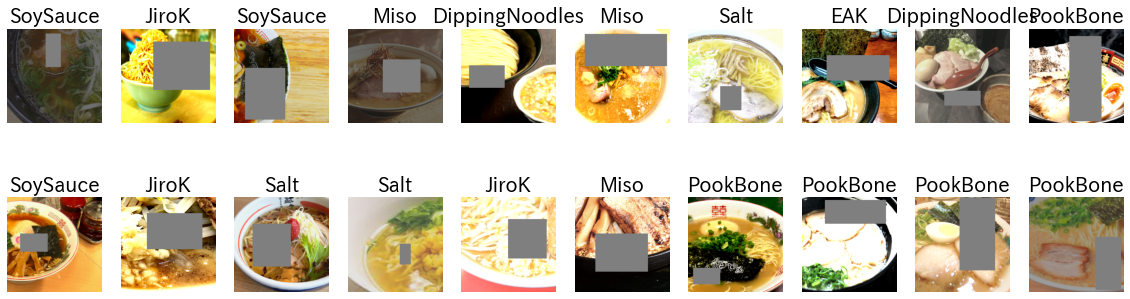

In [16]:
torch_seed()
show_images_labels(train_loader2, classes, None, None)

In [23]:
# 学習済みモデルの読み込み
from torchvision import models
net = models.vit_l_32(weights=models.ViT_L_32_Weights.DEFAULT)

# 全ての層のパラメータを訓練不可に
for param in net.parameters():
    param.requires_grad = False

# 最終層を入れ替え（デフォルトで訓練可能）
net.heads[0] = nn.Linear(1024, len(classes))

# 乱数初期化
torch_seed()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.Adam(net.parameters(), lr=lr)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [24]:
# 学習
num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, None)

  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\peper\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], loss: 1.71179 acc: 0.37278 val_loss: 1.37796, val_acc: 0.67089


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2/20], loss: 1.29339 acc: 0.57988 val_loss: 1.11171, val_acc: 0.72152


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3/20], loss: 1.10165 acc: 0.71598 val_loss: 0.97620, val_acc: 0.72152


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.90193 acc: 0.75740 val_loss: 0.87870, val_acc: 0.65823


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.84829 acc: 0.74556 val_loss: 0.80467, val_acc: 0.69620


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.75392 acc: 0.78402 val_loss: 0.74701, val_acc: 0.73418


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.72294 acc: 0.80473 val_loss: 0.72427, val_acc: 0.68354


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.67305 acc: 0.80769 val_loss: 0.70253, val_acc: 0.70886


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.63637 acc: 0.84024 val_loss: 0.67813, val_acc: 0.72152


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.67895 acc: 0.78994 val_loss: 0.69078, val_acc: 0.74684


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.57351 acc: 0.85799 val_loss: 0.67065, val_acc: 0.68354


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.55261 acc: 0.85799 val_loss: 0.65264, val_acc: 0.70886


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.56356 acc: 0.84320 val_loss: 0.66684, val_acc: 0.74684


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.52270 acc: 0.85799 val_loss: 0.63389, val_acc: 0.73418


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.49297 acc: 0.84320 val_loss: 0.61809, val_acc: 0.78481


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.47080 acc: 0.90533 val_loss: 0.62620, val_acc: 0.78481


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.44873 acc: 0.88462 val_loss: 0.62884, val_acc: 0.78481


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.41979 acc: 0.90237 val_loss: 0.63019, val_acc: 0.77215


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.48126 acc: 0.84911 val_loss: 0.63786, val_acc: 0.77215


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.45999 acc: 0.86686 val_loss: 0.64805, val_acc: 0.78481


初期状態: 損失: 1.37796 精度: 0.67089
最終状態: 損失: 0.64805 精度: 0.78481


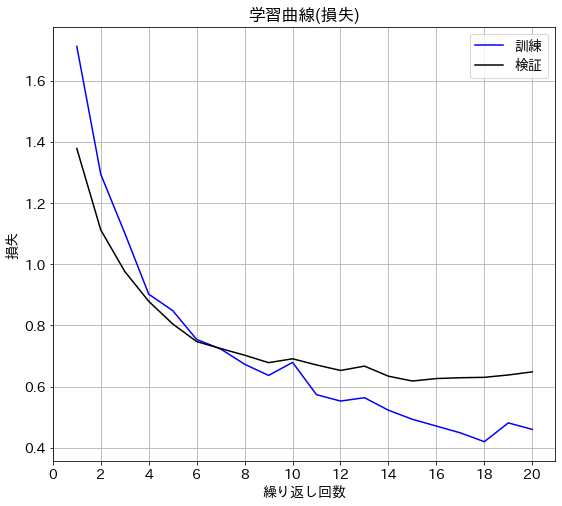

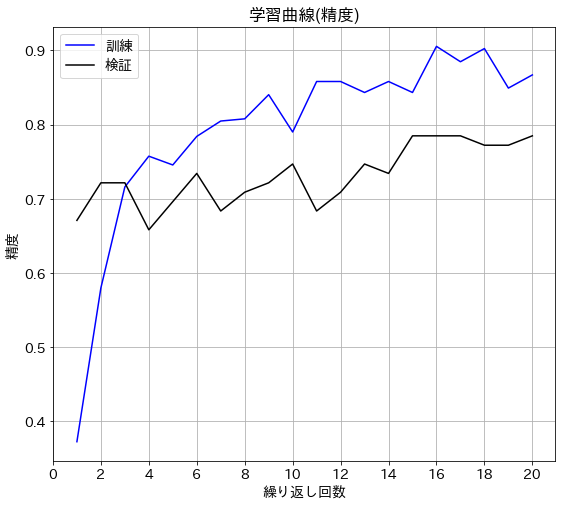

In [25]:
# 結果確認
evaluate_history(history)

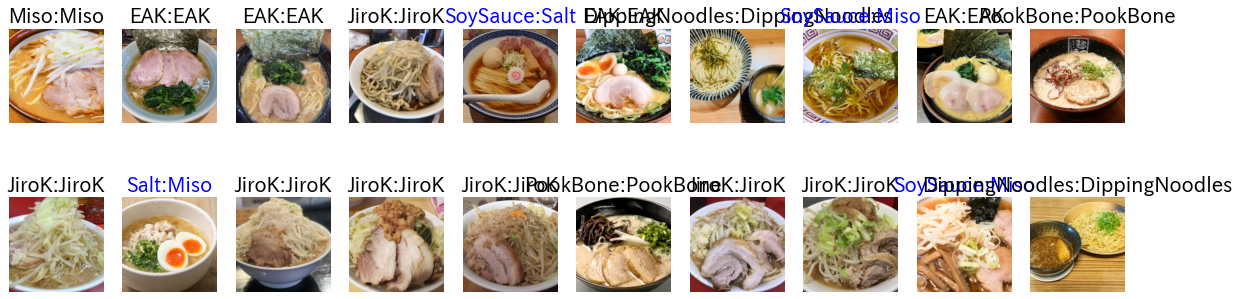

In [26]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)

## 後処理

In [27]:
SaveModel(net, TRAIN_DATA_PATH)

C:\\Users\\peper\\OneDrive\\TrainingData\\RamenAi\\ramen_weights_202305032236.pth


In [51]:
# DataSetフォルダを消す
shutil.rmtree(DATA_SET_PATH)

In [ ]:
# Windowsのスリープ
import ctypes
ctypes.windll.PowrProf.SetSuspendState(0, 1, 0)

1